<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/GymCLIFFDoubleQLearningTODO.ipynb" target="_parent">Ouvrir sur collab</a>


# TP IA Machine Learning
## Liam Boudadi & Chloé Vain
### Groupe TP SI


---

## Test de ML par Simple et Delayed Q-learning pour atteindre l'objectif

**Utilisation de l'environnement gymnasium Cliff Walking**
(voir la page d'introduction à [gymnasium](https://www.gymlibrary.dev/)).


#### Si besoin, installer gym


In [6]:
#!pip install gymnasium 

In [2]:
import gymnasium as gym
import numpy as np
import random as rnd
from tqdm import tqdm

---

- Utiliser l'environnement `CliffWalking` (une grille où il faut trouver le plus court chemin vers l'arrivée)
- Chaque action coûte 1 point, l'arrivée n'en rapporte pas.
- On peut,
  - pour accélérer la résolution en décidant de récompenser l'agent de quelques points s'il parvient au but.
  - ou, _de préférence_, changer la fonction qlearn pour qu'elle retourne
    - total_r : récompense totale;
    - r : récompense du dernier état rencontre
    - states_list : liste des états traverses
    - actions_list : liste des actions effectuées
    - goal : but atteint


## Affichage de du résultat

Affichons maintenant la liste des actions via l'environnement Gym


In [16]:
def rendu(solutions_list):
    """ affiche la plus courte sequence d'actions permettant d'atteindre l'objectif q partir des solutions fournies
    Parameters
    ----------
    solutions_list : liste des solutions trouvees

    Returns
    -------
    None.
    """
    mini_sol = solutions_list[0]
    for s in  solutions_list:
        if len(s[2]) < len(mini_sol[2]): mini_sol = s
    print("une solution en ", len(mini_sol[2]), " etapes : ")
    env.reset()
    env.render()
    for i in range(0, len(mini_sol[2])):
        env.env.s = mini_sol[2][i]
        print("action ", actions[mini_sol[3][i]])
        env.render()

In [ ]:
import matplotlib.pyplot as plt

In [18]:

def plot_frequence_sol(solutions_list):
    """
    dessine la frequence de solution trouvees
    Parameters
    ----------
    solutions : liste des solutions

    Returns
    -------
    None.

    """
    xs = [x[0] for x in solutions_list]
    ys = [y[1] for y in solutions_list]
    plt.figure(figsize=(10, 4))
    plt.plot(xs, ys, '.')
    plt.show()



Plus on relance les tests, plus la chance de trouver une solution peu coûteuse apparaît...


In [20]:
import matplotlib.pyplot as plt

In [21]:
def showBestValues(Q):
    #bestQValues contient les meilleures valeurs des actions possibles pour chaque état
    #et on "dilate" les valeurs pour augmenter leurs différences (utile pour le choix des couleurs)
    bestQ = [-(max(ligne))**50 for ligne in Q]
    #on transforme bestQValues en matrice 4 x 12
    bestQValues = np.reshape(bestQ, (4,12))
    #on demande à python de générer une "heatmap" 
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(bestQValues,cmap='Blues')
    plt.title("Meilleur score d'une action selon l'état")
    plt.show()

In [24]:
import seaborn as sns

In [25]:
# Author: Andrea Pierré
# License: MIT License
def qtable_directions_map(qtable):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(4, 12)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(4, 12)
    directions = {0: "↑", 1: "→", 2: "↓", 3: "←"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = 0#np.finfo(float).min #np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] < eps:
            # Assign an arrow only if a Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(4, 12)
    return qtable_val_max, qtable_directions

In [26]:
# Author: Andrea Pierré
# License: MIT License
def plot_q_values_map(qtable):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
        ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

## L'algorithme de Simple Q-Learning


In [4]:
env = gym.make('CliffWalking-v0', render_mode='ansi')

In [5]:
Q = np.zeros([env.observation_space.n,env.action_space.n])

In [6]:
lambda_learn = .2
gamma = 0.8
epsilon = 1.

In [15]:
def q_learn_simple(nb_actions=64):
    """
    effectue un cycle d'apprentissage/recherche de solution' via le Q-Learning simple

    Parameters
    ----------
    epoch : no de l'etape

    Returns
    -------
    total_r : recompense totale
    r : recompense du dernier etat rencontre
    states_list : liste des etats traverses
    actions_list : liste des actions effectuees

    """
    s = env.reset()
    s = s[0]
    total_r = 0
    done = False
    step = 0
    states_list = []
    actions_list = []
    # The Q-Table learning algorithm
    while not done and step < nb_actions:
        step += 1
        # Choose an action by greedily (with noise) picking from Q table
        actions = Q[s, :]
        if rnd.random()<epsilon or np.max(actions)==0:
            a = rnd.randint(0, env.action_space.n-1)
        else:
            a = np.argmax(actions)

        # Get new state and reward from environment
        new_state, r, done,_, _ = env.step(a)

        # to privilegiate the shortest path, get negative reward every step
        # if r == 0: r = -0.001

        # Q-Learning
        Q[s, a] = (1-lambda_learn)*Q[s, a] + lambda_learn*(r + gamma * np.max(Q[new_state, :]) - Q[s, a])
        s = new_state
        total_r = total_r + r
        states_list.append(s)
        actions_list.append(a)
    return total_r, r, states_list, actions_list, done

In [16]:
def try_qlearn_simple(nb_episodes = 4000, nb_actions = 64):
    """
    lance nb_episodes fois un cycle de Q-Learning et memorise chaque solution trouvee

    Returns
    -------
    solutions_list : liste des solutions (no, recompense totale, liste des etats, liste des actions)
    """
    global epsilon
    states_list = []
    actions_list = []
    solutions_list = []
    epsilon = 1
    for i in tqdm(range(nb_episodes)):
        # Reset environment and get first new observation
        total_r, r, states_list, actions_list, done = q_learn_simple()
        epsilon = epsilon * 0.999
        # memorize if a solution has been found
        if done: solutions_list.append((i, total_r, states_list, actions_list))
        
    if(len(solutions_list) == 0): print("aucune solution trouvee !!")
    return solutions_list

In [11]:
def rendu_simple(solutions_list):
    """ affiche la plus courte sequence d'actions permettant d'atteindre l'objectif q partir des solutions fournies
    Parameters
    ----------
    solutions_list : liste des solutions trouvees

    Returns
    -------
    None.
    """
    mini_sol = solutions_list[0]
    mini_actions = mini_sol[2]
    for s in  solutions_list:
        if len(s[2]) < len(mini_sol[2]): 
            mini_sol = s
            mini_actions = s[3]
    print("une solution en ", len(mini_sol[2]), " etapes : ")
    env.reset()
    print(env.render())
    for a in mini_actions:
        env.step(a)
        print(env.render())

In [17]:
##ON LANCE LA RESOLUTION : 
solutions_simple = try_qlearn_simple(3000, 50)
if(len(solutions_simple)>0):rendu_simple(solutions_simple)
#relancer le bloc si pas de solution trouvee

100%|██████████| 3000/3000 [00:04<00:00, 727.54it/s] 

une solution en  13  etapes : 
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  

In [19]:
import matplotlib.pyplot as plt
def plot_frequence_sol(solutions_list):
    """
    dessine la frequence de solution trouvees
    Parameters
    ----------
    solutions : liste des solutions

    Returns
    -------
    None.

    """
    xs = [x[0] for x in solutions_list]
    ys = [y[1] for y in solutions_list]
    plt.figure(figsize=(10, 4))
    plt.plot(xs, ys, '.')
    plt.xlabel("no du test")
    plt.ylabel("gain")    
    plt.title("Fréquence d'apparition de solution")
    plt.show()

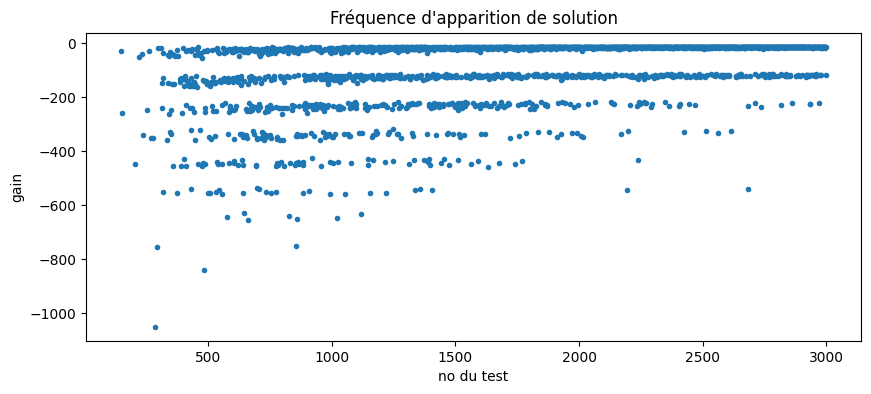

In [20]:
plot_frequence_sol(solutions_simple)

In [21]:
def showBestValues(Q):
    #bestQValues contient les meilleures valeurs des actions possibles pour chaque état
    #et on "dilate" les valeurs pour augmenter leurs différences (utile pour le choix des couleurs)
    bestQ = [-(max(ligne))**50 for ligne in Q]
    #on transforme bestQValues en matrice 4 x 12
    bestQValues = np.reshape(bestQ, (4,12))
    #on demande à python de générer une "heatmap" 
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(bestQValues,cmap='Blues')
    plt.title("Meilleur score d'une action selon l'état")
    plt.show()

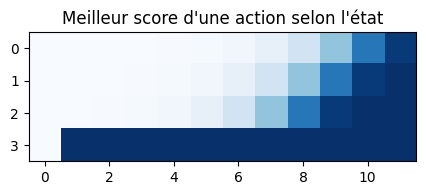

In [22]:
showBestValues(Q)

## L'algotithme Delayed Q-Learning


In [40]:
import numpy as np
import random as rnd
from tqdm import tqdm

env = gym.make('CliffWalking-v0', render_mode='ansi')


In [41]:
Q = np.zeros([env.observation_space.n,env.action_space.n])

In [42]:
lambda_learn = .2
gamma = 0.8
epsilon = 1.

In [43]:
def q_learn_delayed(nb_actions=64, m=10):
    """
    effectue un cycle d'apprentissage/recherche de solution' via le Q-Learning simple

    Parameters
    ----------
    epoch : no de l'etape

    Returns
    -------
    total_r : recompense totale
    r : recompense du dernier etat rencontre
    states_list : liste des etats traverses
    actions_list : liste des actions effectuees

    """
    s = env.reset()
    s = s[0]
    total_r = 0
    done = False
    step = 0
    states_list = []
    actions_list = []
    memory = []
    # The Q-Table learning algorithm
    while not done and step < nb_actions:
        step += 1
        # Choose an action by greedily (with noise) picking from Q table
        actions = Q[s, :]
        if rnd.random()<epsilon or np.max(actions)==0:
            a = rnd.randint(0, env.action_space.n-1)
        else:
            a = np.argmax(actions)

        # Get new state and reward from environment
        new_state, r, done,_, _ = env.step(a)
        memory.append((s, a, r, new_state))

        # to privilegiate the shortest path, get negative reward every step
        # if r == 0: r = -0.001

        # Q-Learning
        if step%m == 0:
            for s, a, r, new_state in memory:
                Q[s, a] = Q[s, a] + lambda_learn*(r + gamma * np.max(Q[new_state, :]) - Q[s, a])
                total_r = total_r + r
            memory.clear()

        s = new_state
        
        states_list.append(s)
        actions_list.append(a)
    return total_r, r, states_list, actions_list

In [44]:
def try_qlearn_delayed(nb_episodes = 4000, nb_actions = 64):
    """
    lance nb_episodes fois un cycle de Q-Learning et memorise chaque solution trouvee

    Returns
    -------
    solutions_list : liste des solutions (no, recompense totale, liste des etats, liste des actions)
    """
    global epsilon
    states_list = []
    actions_list = []
    solutions_list = []
    epsilon = 1
    for i in tqdm(range(nb_episodes)):
        # Reset environment and get first new observation
        total_r, r, states_list, actions_list = q_learn_delayed()
        epsilon = epsilon * 0.999
        # memorize if a solution has been found
        if done: solutions_list.append((i, total_r, states_list, actions_list))
        
    if(len(solutions_list) == 0): print("aucune solution trouvee !!")
    return solutions_list

In [45]:
def rendu_delayed(solutions_list):
    """ affiche la plus courte sequence d'actions permettant d'atteindre l'objectif q partir des solutions fournies
    Parameters
    ----------
    solutions_list : liste des solutions trouvees

    Returns
    -------
    None.
    """
    mini_sol = solutions_list[0]
    mini_actions = mini_sol[2]
    for s in  solutions_list:
        if len(s[2]) < len(mini_sol[2]): 
            mini_sol = s
            mini_actions = s[3]
    print("une solution en ", len(mini_sol[2]), " etapes : ")
    env.reset()
    print(env.render())
    for a in mini_actions:
        env.step(a)
        print(env.render())

In [46]:
##ON LANCE LA RESOLUTION : 
solutions_delayed = try_qlearn_delayed(3000, 50)
if(len(solutions_delayed)>0):rendu_delayed(solutions_delayed)
#relancer le bloc si pas de solution trouvee

100%|██████████| 3000/3000 [00:01<00:00, 1912.06it/s]

une solution en  13  etapes : 
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  

In [47]:
import matplotlib.pyplot as plt
def plot_frequence_sol(solutions_list):
    """
    dessine la frequence de solution trouvees
    Parameters
    ----------
    solutions : liste des solutions

    Returns
    -------
    None.

    """
    xs = [x[0] for x in solutions_list]
    ys = [y[1] for y in solutions_list]
    plt.figure(figsize=(10, 4))
    plt.plot(xs, ys, '.')
    plt.xlabel("no du test")
    plt.ylabel("gain")    
    plt.title("Fréquence d'apparition de solution")
    plt.show()

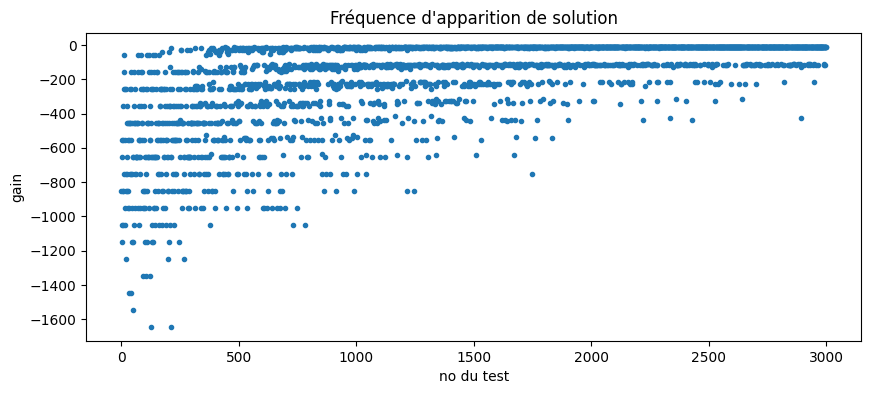

In [48]:
plot_frequence_sol(solutions_delayed)

In [54]:
def showBestValues(Q):
    #bestQValues contient les meilleures valeurs des actions possibles pour chaque état
    #et on "dilate" les valeurs pour augmenter leurs différences (utile pour le choix des couleurs)
    bestQ = [-(max(ligne))**50 for ligne in Q]
    #on transforme bestQValues en matrice 4 x 12
    bestQValues = np.reshape(bestQ, (4,12))
    #on demande à python de générer une "heatmap" 
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(bestQValues,cmap='Blues')
    plt.title("Meilleur score d'une action selon l'état")
    plt.show()

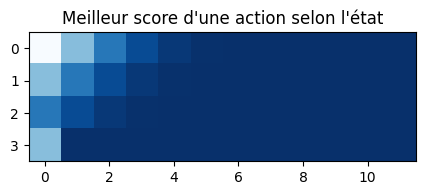

In [50]:
showBestValues(Q)

In [51]:
# Author: Andrea Pierré
# License: MIT License
def plot_q_values_map(qtable):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
        ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

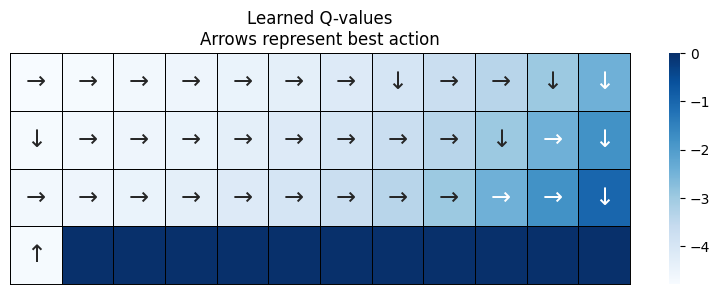

In [52]:
plot_q_values_map(Q)